In [1]:
import comet_ml
from comet_ml.query import Parameter
import pandas as pd

In [2]:
comet_api = comet_ml.api.API()
fedavgm_query = Parameter('SERVER_OPT_MOMENTUM') != None
short_exps = comet_api.query('federated-learning', 'server-side-opt', fedavgm_query)
long_exps = comet_api.query('federated-learning', 'server-side-opt-long', fedavgm_query)

In [4]:
def get_df(exps):
    clrs = [float(exp.get_parameters_summary('CLIENT_LEARNING_RATE')['valueMax']) for exp in exps]
    slrs = [float(exp.get_parameters_summary('SERVER_LEARNING_RATE')['valueMax']) for exp in exps]
    sopts = [exp.get_parameters_summary('SERVER_OPT')['valueMax'] for exp in exps]
    teas = [float(exp.get_metrics_summary('test_acc')['valueMax']) for exp in exps]
    ids = [exp.id for exp in exps]
    return pd.DataFrame({'id': ids, 'client lr': clrs, 'server lr': slrs, 'server opt': sopts, 'test_acc': teas})

In [15]:
short_df = get_df(short_exps)
long_df = get_df(long_exps)

In [16]:
short_df = short_df.sort_values('test_acc', ascending=False)
short_df['short_order'] = range(len(short_df))
long_df = long_df.sort_values('test_acc', ascending=False)
long_df['long_order'] = range(len(long_df))

In [36]:
result_df = long_df[['client lr', 'server lr', 'long_order']].join(short_df[['client lr', 'server lr', 'short_order']].set_index(['client lr', 'server lr']), on=['client lr', 'server lr'], lsuffix='_caller', rsuffix='_other').sort_values('short_order')[['short_order', 'long_order']]

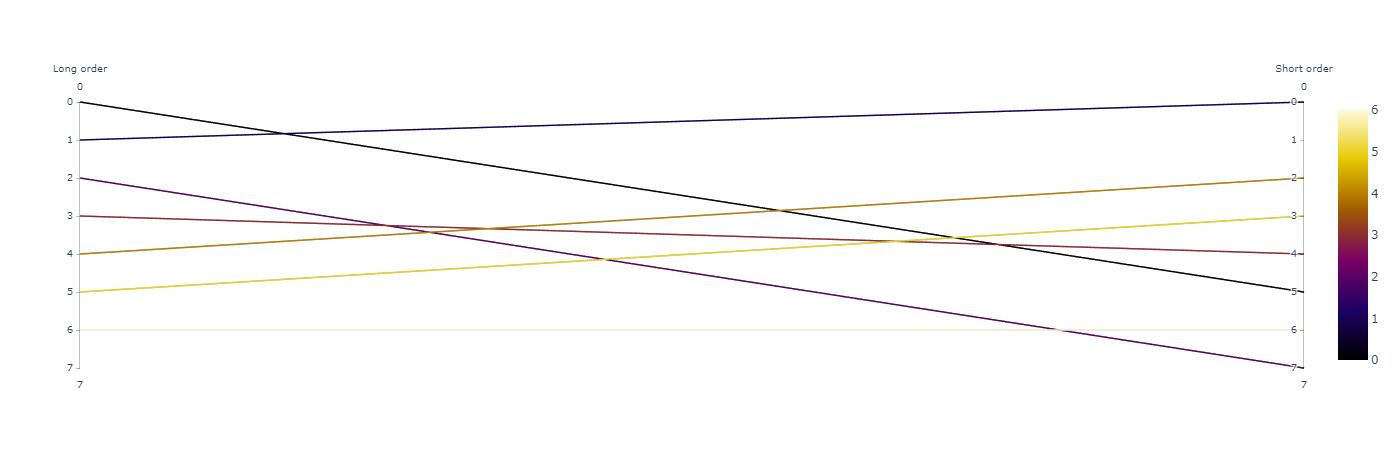

,short_order,long_order
0,0,1
1,2,4
2,3,5
3,4,3
4,5,0
5,6,6
6,7,2


In [48]:
# import plotly.express as px
# fig = px.parallel_coordinates(result_df, color="long_order",  labels={"long_order": "long order", "short_order": "short order" })
# fig.show()

import plotly.graph_objects as go
fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = result_df['long_order'],
                   colorscale = 'Electric',
                   showscale = True),
        dimensions = list([
            dict(range = [len(result_df['long_order']), 0],
                 label = 'Long order', values = result_df['long_order']),
        
            dict(range = [len(result_df['short_order']), 0],
                 label = 'Short order', values = result_df['short_order'])])
    )
)
fig.show()
result_df